In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os

In [8]:
p = pd.read_csv("../data/pit_clean.csv")
b = pd.read_csv("../data/bat_clean.csv")

In [9]:
p.isna().sum().sort_values(ascending=False)

contract_years    134
total_value       134
wCT/C             106
CTv               106
CT%               106
                 ... 
Zone%               0
F-Strike%           0
SwStr%              0
HLD                 0
salary_M            0
Length: 302, dtype: int64

In [10]:
b.isna().sum().sort_values(ascending=False)

contract_years    374
total_value       373
UBR               154
wGDP              154
phLI              125
                 ... 
wSL/C               0
wCT/C               0
wCB/C               0
wCH/C               0
salary_M            0
Length: 267, dtype: int64

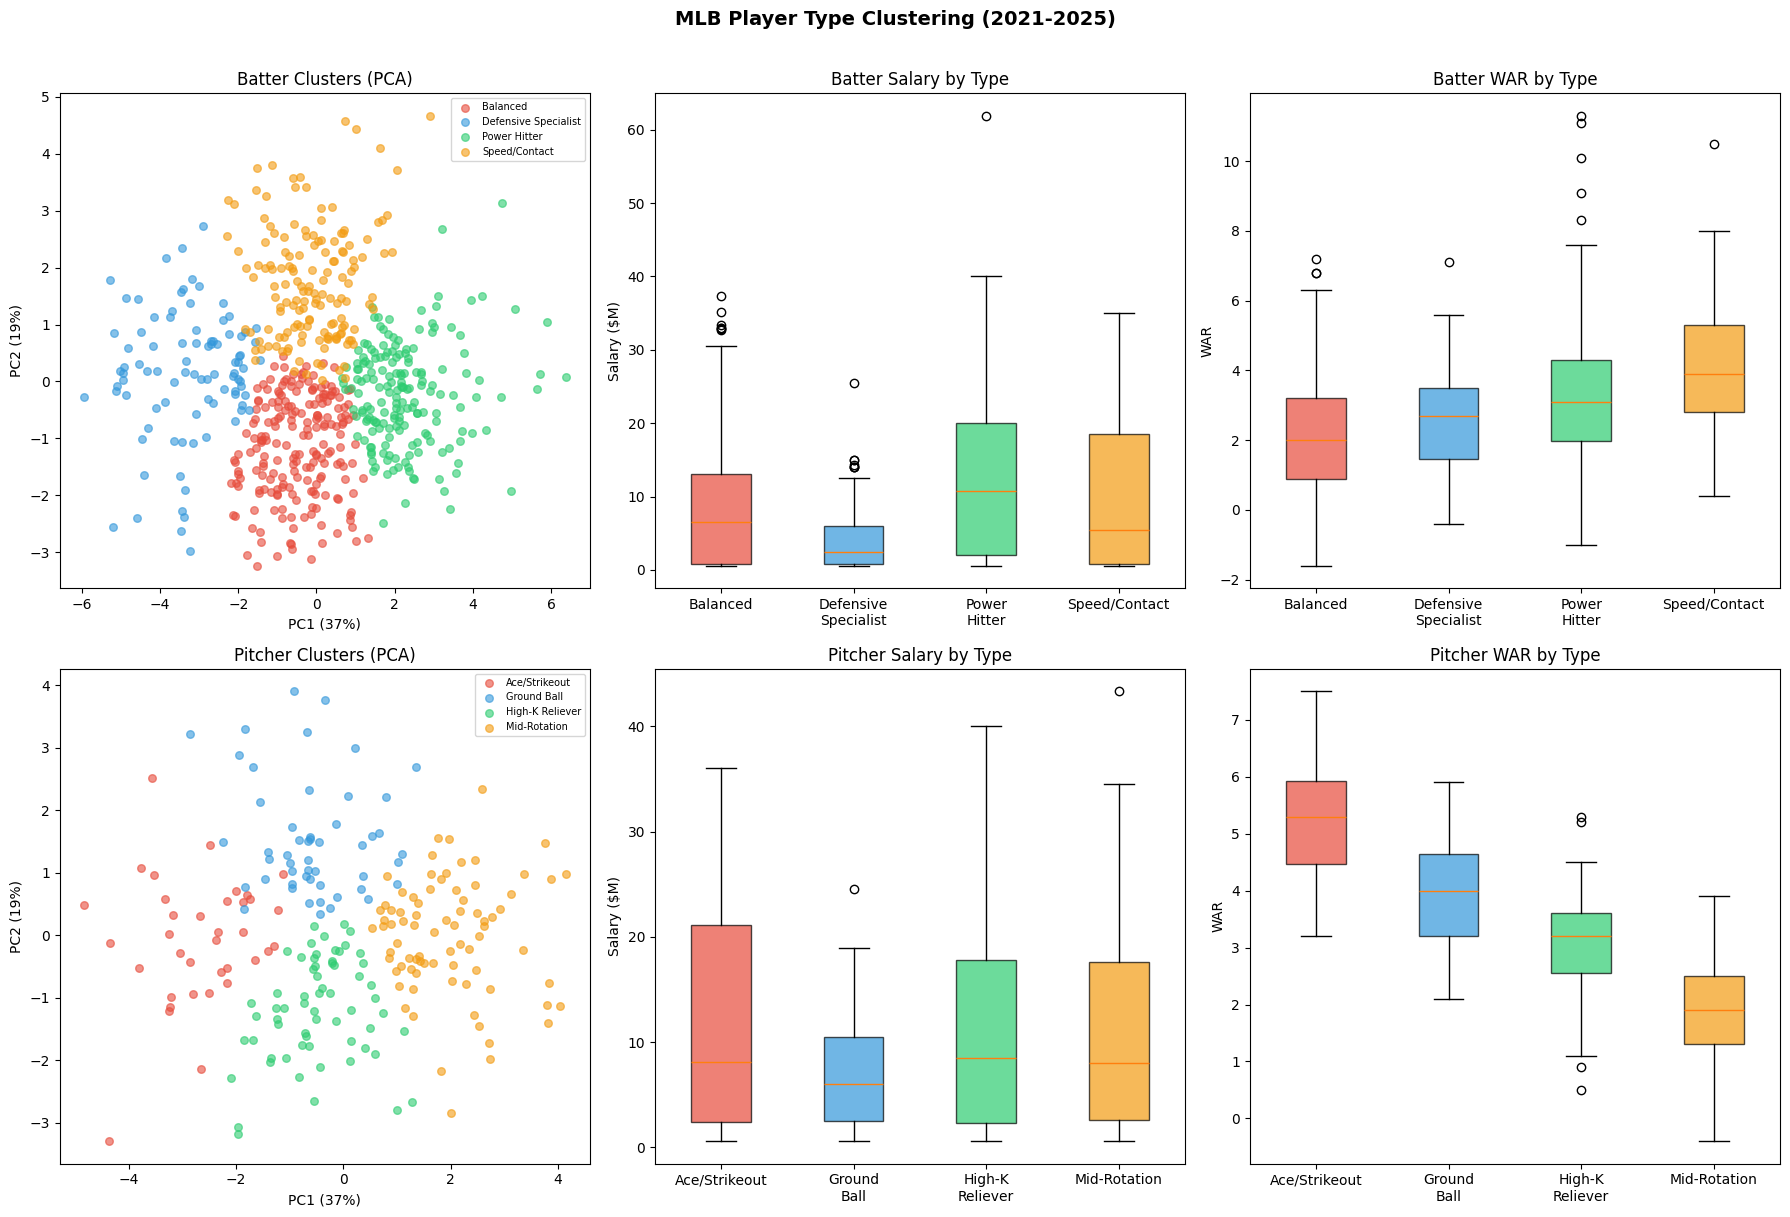

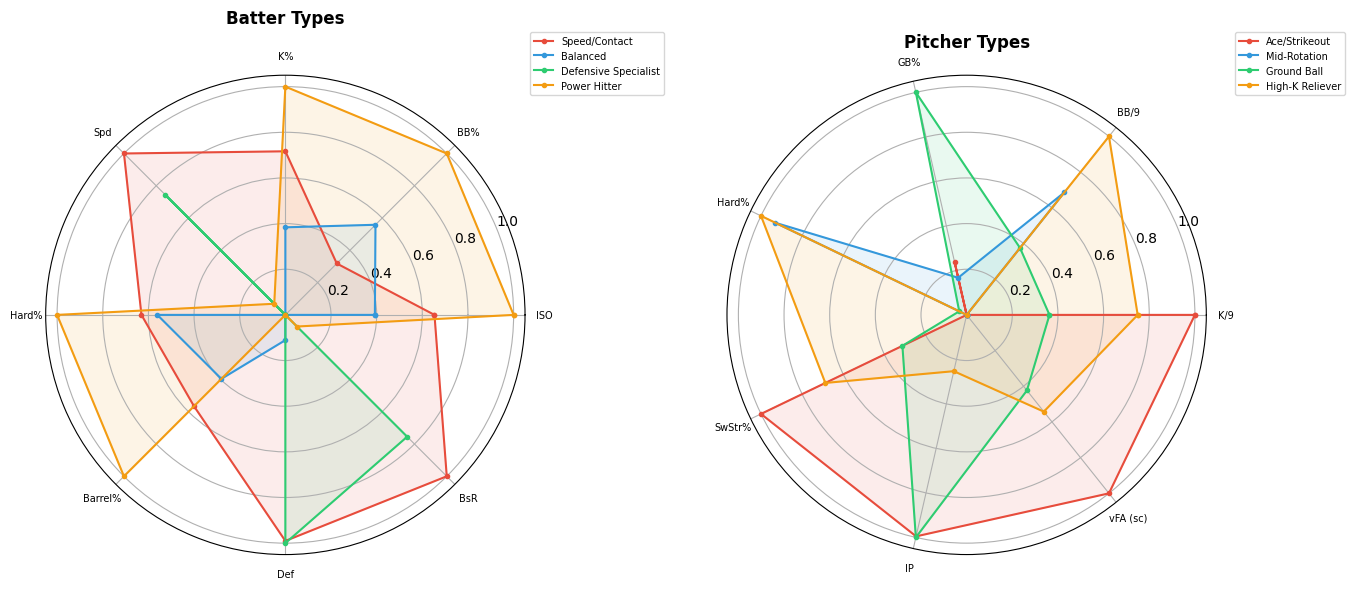

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
pit = pd.read_csv("../data/pit_clean.csv")
bat = pd.read_csv('../data/bat_clean.csv')

# ============================================================
# 타자 클러스터링
# ============================================================
bat_features = ['ISO', 'BB%', 'K%', 'Spd', 'Hard%', 'GB%', 'Pull%', 'Barrel%', 'SwStr%', 'Def', 'BsR']
bat_cluster_df = bat[bat_features + ['player', 'season', 'salary_M', 'WAR', 'HR', 'SB', 'wRC+', 'team']].dropna()

scaler_b = StandardScaler()
X_bat = scaler_b.fit_transform(bat_cluster_df[bat_features])

km_bat = KMeans(n_clusters=4, random_state=42, n_init=10)
bat_cluster_df['cluster'] = km_bat.fit_predict(X_bat)

# 클러스터별 프로필
cluster_profiles_bat = bat_cluster_df.groupby('cluster')[bat_features + ['WAR', 'salary_M', 'HR', 'SB', 'wRC+']].mean()

# 클러스터 이름 부여
def label_bat_cluster(row):
    profiles = cluster_profiles_bat
    c = row.name
    iso_rank = profiles['ISO'].rank()[c]
    spd_rank = profiles['Spd'].rank()[c]
    def_rank = profiles['Def'].rank()[c]
    if iso_rank == 4:
        return 'Power Hitter'
    elif spd_rank == 4:
        return 'Speed/Contact'
    elif def_rank == 4:
        return 'Defensive Specialist'
    else:
        return 'Balanced'

cluster_labels_bat = cluster_profiles_bat.apply(label_bat_cluster, axis=1).to_dict()
bat_cluster_df['type'] = bat_cluster_df['cluster'].map(cluster_labels_bat)

# ============================================================
# 투수 클러스터링
# ============================================================
pit_features = ['K/9', 'BB/9', 'HR/9', 'GB%', 'Hard%', 'SwStr%', 'vFA (sc)', 'IP', 'SIERA']
pit_cluster_df = pit[pit_features + ['player', 'season', 'salary_M', 'WAR', 'ERA', 'GS', 'SV', 'team']].dropna()

scaler_p = StandardScaler()
X_pit = scaler_p.fit_transform(pit_cluster_df[pit_features])

km_pit = KMeans(n_clusters=4, random_state=42, n_init=10)
pit_cluster_df['cluster'] = km_pit.fit_predict(X_pit)

cluster_profiles_pit = pit_cluster_df.groupby('cluster')[pit_features + ['WAR', 'salary_M', 'ERA', 'GS', 'SV']].mean()

def label_pit_cluster(row):
    profiles = cluster_profiles_pit
    c = row.name
    k9_rank = profiles['K/9'].rank()[c]
    gb_rank = profiles['GB%'].rank()[c]
    ip_rank = profiles['IP'].rank()[c]
    if k9_rank == 4 and ip_rank >= 3:
        return 'Ace/Strikeout'
    elif gb_rank == 4:
        return 'Ground Ball'
    elif ip_rank == 4:
        return 'Workhorse'
    elif ip_rank <= 2 and k9_rank >= 3:
        return 'High-K Reliever'
    else:
        return 'Mid-Rotation'

cluster_labels_pit = cluster_profiles_pit.apply(label_pit_cluster, axis=1).to_dict()
pit_cluster_df['type'] = pit_cluster_df['cluster'].map(cluster_labels_pit)

# ============================================================
# 시각화 - PCA + 연봉 + WAR 박스플롯
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 타자 PCA
pca_b = PCA(n_components=2)
X_pca_b = pca_b.fit_transform(X_bat)
colors_b = {t: c for t, c in zip(sorted(bat_cluster_df['type'].unique()),
            ['#e74c3c', '#3498db', '#2ecc71', '#f39c12'])}

ax = axes[0, 0]
for t, color in colors_b.items():
    mask = bat_cluster_df['type'] == t
    ax.scatter(X_pca_b[mask, 0], X_pca_b[mask, 1], c=color, label=t, alpha=0.6, s=30)
ax.set_xlabel(f'PC1 ({pca_b.explained_variance_ratio_[0]:.0%})')
ax.set_ylabel(f'PC2 ({pca_b.explained_variance_ratio_[1]:.0%})')
ax.set_title('Batter Clusters (PCA)')
ax.legend(fontsize=7)

# 타자 연봉 박스플롯
ax = axes[0, 1]
types_b = sorted(bat_cluster_df['type'].unique())
bp = ax.boxplot([bat_cluster_df[bat_cluster_df['type']==t]['salary_M'].values for t in types_b],
                labels=[t.replace(' ','\n') for t in types_b], patch_artist=True)
for patch, t in zip(bp['boxes'], types_b):
    patch.set_facecolor(colors_b[t]); patch.set_alpha(0.7)
ax.set_ylabel('Salary ($M)'); ax.set_title('Batter Salary by Type')

# 타자 WAR 박스플롯
ax = axes[0, 2]
bp = ax.boxplot([bat_cluster_df[bat_cluster_df['type']==t]['WAR'].values for t in types_b],
                labels=[t.replace(' ','\n') for t in types_b], patch_artist=True)
for patch, t in zip(bp['boxes'], types_b):
    patch.set_facecolor(colors_b[t]); patch.set_alpha(0.7)
ax.set_ylabel('WAR'); ax.set_title('Batter WAR by Type')

# 투수 PCA
pca_p = PCA(n_components=2)
X_pca_p = pca_p.fit_transform(X_pit)
colors_p = {t: c for t, c in zip(sorted(pit_cluster_df['type'].unique()),
            ['#e74c3c', '#3498db', '#2ecc71', '#f39c12'])}

ax = axes[1, 0]
for t, color in colors_p.items():
    mask = pit_cluster_df['type'] == t
    ax.scatter(X_pca_p[mask, 0], X_pca_p[mask, 1], c=color, label=t, alpha=0.6, s=30)
ax.set_xlabel(f'PC1 ({pca_p.explained_variance_ratio_[0]:.0%})')
ax.set_ylabel(f'PC2 ({pca_p.explained_variance_ratio_[1]:.0%})')
ax.set_title('Pitcher Clusters (PCA)')
ax.legend(fontsize=7)

# 투수 연봉 박스플롯
ax = axes[1, 1]
types_p = sorted(pit_cluster_df['type'].unique())
bp = ax.boxplot([pit_cluster_df[pit_cluster_df['type']==t]['salary_M'].values for t in types_p],
                labels=[t.replace(' ','\n') for t in types_p], patch_artist=True)
for patch, t in zip(bp['boxes'], types_p):
    patch.set_facecolor(colors_p[t]); patch.set_alpha(0.7)
ax.set_ylabel('Salary ($M)'); ax.set_title('Pitcher Salary by Type')

# 투수 WAR 박스플롯
ax = axes[1, 2]
bp = ax.boxplot([pit_cluster_df[pit_cluster_df['type']==t]['WAR'].values for t in types_p],
                labels=[t.replace(' ','\n') for t in types_p], patch_artist=True)
for patch, t in zip(bp['boxes'], types_p):
    patch.set_facecolor(colors_p[t]); patch.set_alpha(0.7)
ax.set_ylabel('WAR'); ax.set_title('Pitcher WAR by Type')

plt.suptitle('MLB Player Type Clustering (2021-2025)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
#plt.savefig('./data/clustering_overview.png', bbox_inches='tight', dpi=150)
#plt.show()

# ============================================================
# 레이더 차트
# ============================================================
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(polar=True))

def radar_chart(ax, profiles, features, labels, colors_dict, title):
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]
    normalized = profiles[features].copy()
    for col in features:
        mn, mx = normalized[col].min(), normalized[col].max()
        if mx > mn:
            normalized[col] = (normalized[col] - mn) / (mx - mn)
        else:
            normalized[col] = 0.5
    for idx, (cid, row) in enumerate(normalized.iterrows()):
        values = row.tolist() + row.tolist()[:1]
        lbl = labels[cid]
        color = list(colors_dict.values())[idx % len(colors_dict)]
        ax.plot(angles, values, 'o-', linewidth=1.5, label=lbl, color=color, markersize=3)
        ax.fill(angles, values, alpha=0.1, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, size=7)
    ax.set_title(title, pad=20, fontweight='bold')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=7)

radar_chart(ax1, cluster_profiles_bat, ['ISO','BB%','K%','Spd','Hard%','Barrel%','Def','BsR'],
            cluster_labels_bat, colors_b, 'Batter Types')
radar_chart(ax2, cluster_profiles_pit, ['K/9','BB/9','GB%','Hard%','SwStr%','IP','vFA (sc)'],
            cluster_labels_pit, colors_p, 'Pitcher Types')

plt.tight_layout()
#plt.savefig('./data/clustering_radar.png', bbox_inches='tight', dpi=150)
#plt.show()

# 저장
#bat_cluster_df.to_csv('./data/bat_clustered.csv', index=False, encoding='utf-8-sig')
#pit_cluster_df.to_csv('./data/pit_clustered.csv', index=False, encoding='utf-8-sig')
#print('저장 완료: bat_clustered.csv, pit_clustered.csv')

In [20]:
pit = pd.read_csv("../data/pit_clean.csv")
bat = pd.read_csv('../data/bat_clean.csv')

print(bat.columns.tolist())
print(pit.columns.tolist())

['season', 'team', 'position', 'name_key', 'salary', 'total_value', 'IDfg', 'Team', 'Age', 'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'AVG', 'GB', 'FB', 'LD', 'IFFB', 'Pitches', 'Balls', 'Strikes', 'IFH', 'BU', 'BUH', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%', 'BUH%', 'wOBA', 'wRAA', 'wRC', 'Bat', 'Fld', 'Rep', 'Pos', 'RAR', 'WAR', 'Dol', 'Spd', 'wRC+', 'WPA', '-WPA', '+WPA', 'RE24', 'REW', 'pLI', 'phLI', 'PH', 'WPA/LI', 'Clutch', 'FB% (Pitch)', 'FBv', 'SL%', 'SLv', 'CT%', 'CTv', 'CB%', 'CBv', 'CH%', 'CHv', 'SF%', 'SFv', 'XX%', 'wFB', 'wSL', 'wCT', 'wCB', 'wCH', 'wSF', 'wFB/C', 'wSL/C', 'wCT/C', 'wCB/C', 'wCH/C', 'wSF/C', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'BsR', 'FA% (sc)', 'FC% (sc)', 'FS% (sc)', 'SI% (sc)', 'SL% (sc)', 'CU% (sc)', 'KC% (sc)', 'CH% (sc)', 'vFA (sc)', 'vFC (

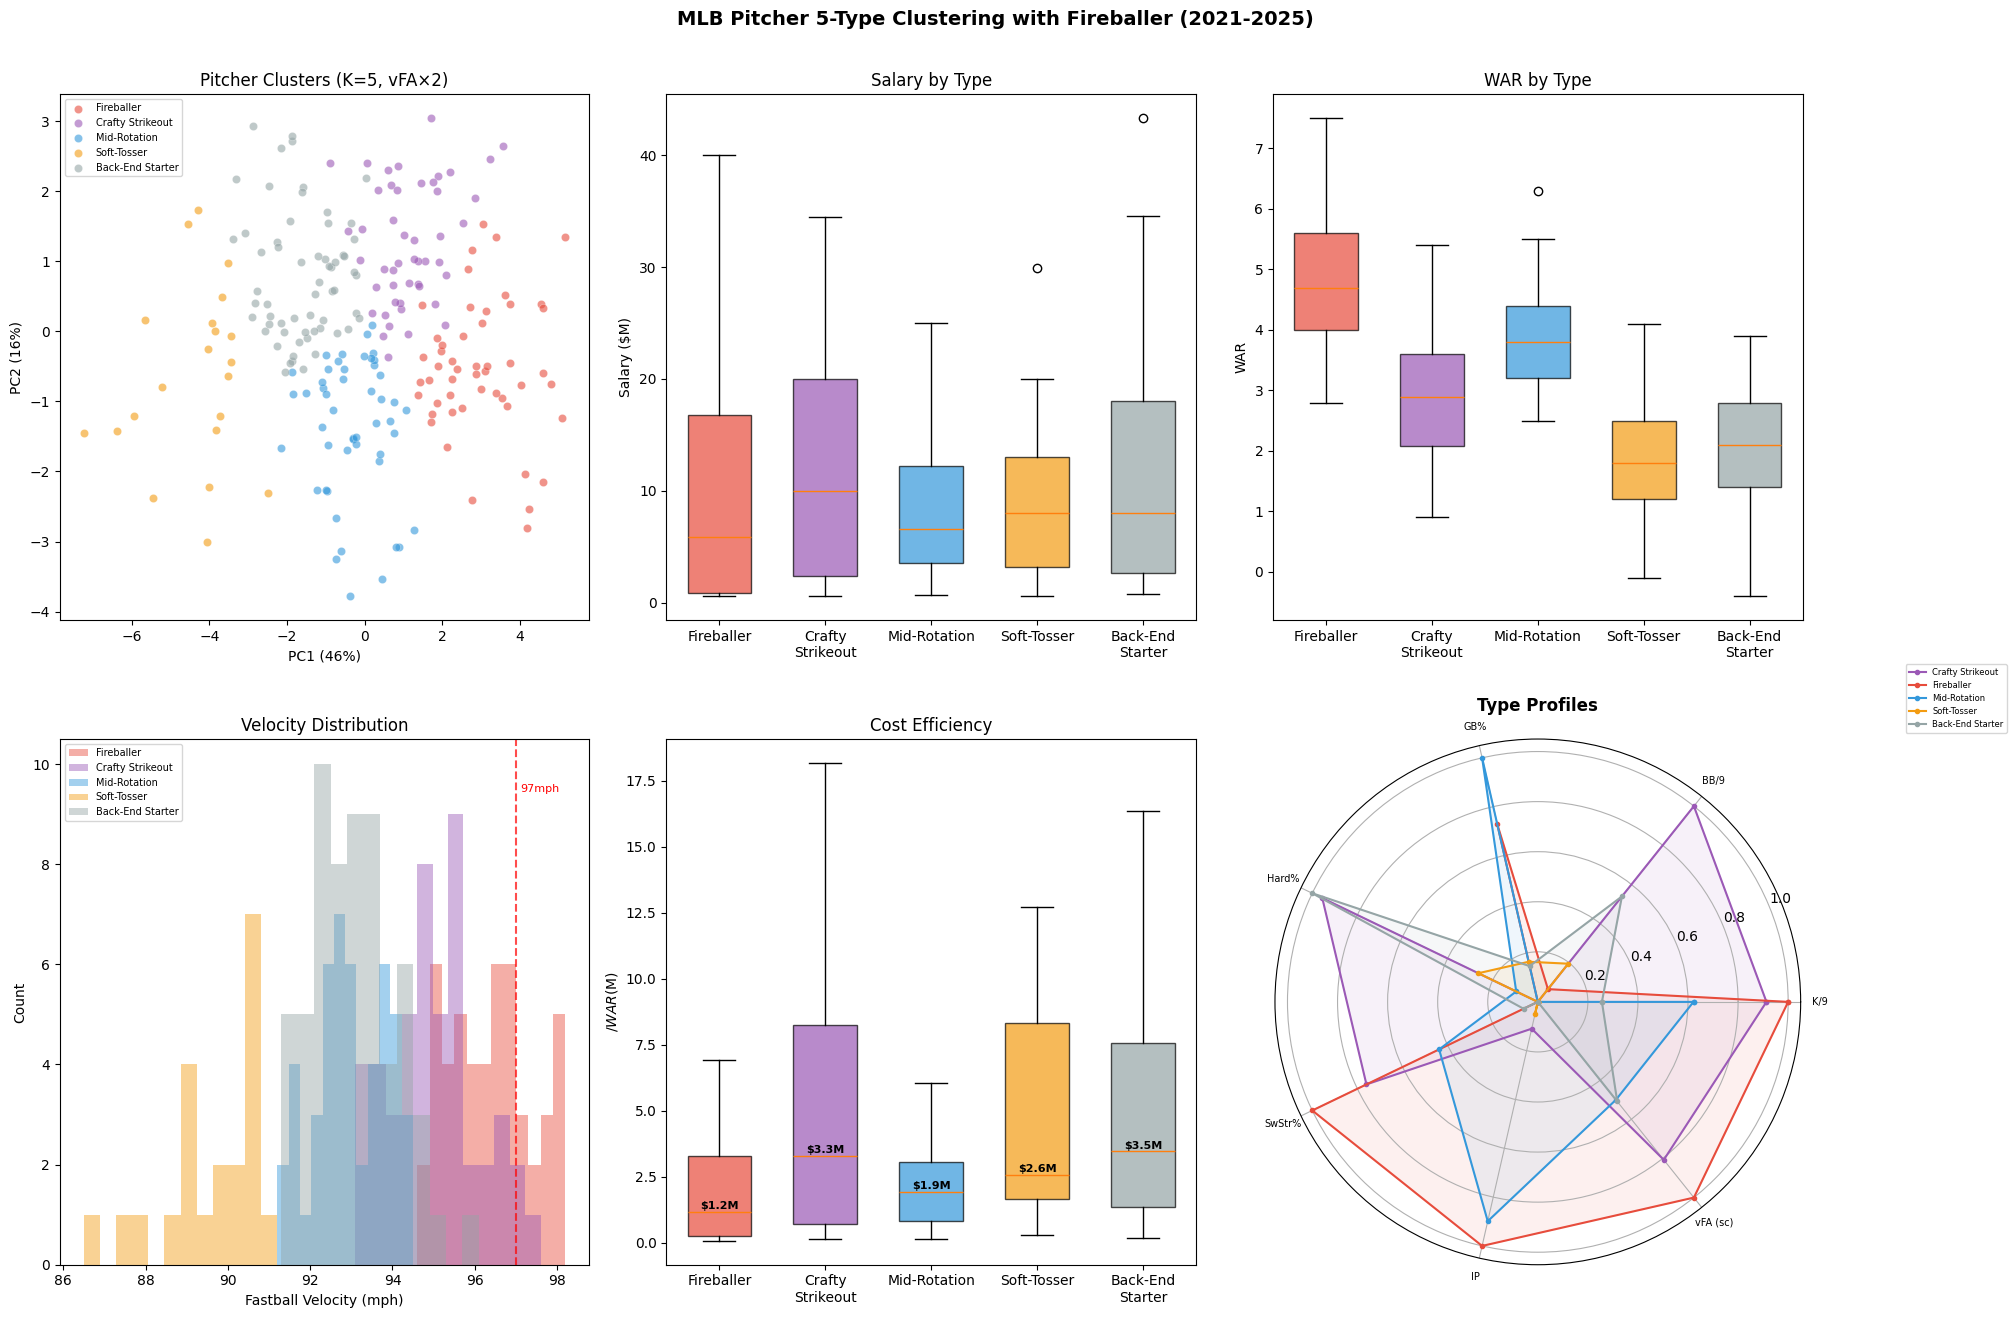

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
pit = pd.read_csv('../data/pit_clean.csv')

# ============================================================
# 투수 K=5 클러스터링 (vFA 가중치 2배)
# ============================================================
pit_features = ['K/9', 'BB/9', 'HR/9', 'GB%', 'Hard%', 'SwStr%', 'vFA (sc)', 'IP', 'SIERA']
pit_df = pit[pit_features + ['player', 'season', 'salary_M', 'WAR', 'ERA', 'GS', 'SV', 'team']].dropna()

scaler = StandardScaler()
X = scaler.fit_transform(pit_df[pit_features])

# vFA 가중치 2배
X[:, pit_features.index('vFA (sc)')] *= 2.0

km = KMeans(n_clusters=5, random_state=42, n_init=10)
pit_df['cluster'] = km.fit_predict(X)

profiles = pit_df.groupby('cluster')[pit_features + ['WAR', 'salary_M', 'ERA']].mean()

# ============================================================
# 클러스터 라벨링
# ============================================================
from collections import Counter

manual_labels = {}
for c in profiles.index:
    vfa = profiles.loc[c, 'vFA (sc)']
    k9  = profiles.loc[c, 'K/9']
    gb  = profiles.loc[c, 'GB%']
    ip  = profiles.loc[c, 'IP']

    if vfa >= 96 and k9 >= 9.5:
        manual_labels[c] = 'Fireballer'
    elif gb >= 0.48 and ip >= 185:
        manual_labels[c] = 'Ground Ball Ace'
    elif k9 >= 9 and vfa < 96 and ip >= 170:
        manual_labels[c] = 'Crafty Strikeout'
    elif vfa <= 91:
        manual_labels[c] = 'Soft-Tosser'
    else:
        manual_labels[c] = 'Mid-Rotation'

# 중복 라벨 처리
label_counts = Counter(manual_labels.values())
for lbl, cnt in label_counts.items():
    if cnt > 1:
        dupes = [k for k, v in manual_labels.items() if v == lbl]
        dupes_sorted = sorted(dupes, key=lambda c: profiles.loc[c, 'WAR'], reverse=True)
        for i, c in enumerate(dupes_sorted):
            if i > 0:
                manual_labels[c] = 'Back-End Starter'

pit_df['type'] = pit_df['cluster'].map(manual_labels)

type_order = [t for t in ['Fireballer', 'Crafty Strikeout', 'Mid-Rotation', 'Ground Ball Ace', 'Soft-Tosser', 'Back-End Starter']
              if t in pit_df['type'].unique()]

# ============================================================
# 시각화
# ============================================================
colors = {
    'Fireballer': '#e74c3c', 'Ground Ball Ace': '#2ecc71',
    'Crafty Strikeout': '#9b59b6', 'Mid-Rotation': '#3498db',
    'Soft-Tosser': '#f39c12', 'Back-End Starter': '#95a5a6'
}

fig, axes = plt.subplots(2, 3, figsize=(20, 13))

# 1) PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
ax = axes[0, 0]
for t in type_order:
    mask = pit_df['type'] == t
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors.get(t), label=t, alpha=0.6, s=35,
               edgecolors='white', linewidth=0.3)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.0%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.0%})')
ax.set_title('Pitcher Clusters (K=5, vFA×2)')
ax.legend(fontsize=7)

# 2) Salary 박스플롯
ax = axes[0, 1]
bp = ax.boxplot([pit_df[pit_df['type'] == t]['salary_M'].values for t in type_order],
                labels=[t.replace(' ', '\n') for t in type_order], patch_artist=True, widths=0.6)
for patch, t in zip(bp['boxes'], type_order):
    patch.set_facecolor(colors.get(t)); patch.set_alpha(0.7)
ax.set_ylabel('Salary ($M)'); ax.set_title('Salary by Type')

# 3) WAR 박스플롯
ax = axes[0, 2]
bp = ax.boxplot([pit_df[pit_df['type'] == t]['WAR'].values for t in type_order],
                labels=[t.replace(' ', '\n') for t in type_order], patch_artist=True, widths=0.6)
for patch, t in zip(bp['boxes'], type_order):
    patch.set_facecolor(colors.get(t)); patch.set_alpha(0.7)
ax.set_ylabel('WAR'); ax.set_title('WAR by Type')

# 4) 구속 분포
ax = axes[1, 0]
for t in type_order:
    sub = pit_df[pit_df['type'] == t]['vFA (sc)']
    ax.hist(sub, bins=12, alpha=0.45, label=t, color=colors.get(t))
ax.axvline(x=97, color='red', linestyle='--', alpha=0.7)
ax.text(97.1, ax.get_ylim()[1] * 0.9, '97mph', color='red', fontsize=8)
ax.set_xlabel('Fastball Velocity (mph)'); ax.set_ylabel('Count')
ax.set_title('Velocity Distribution'); ax.legend(fontsize=7)

# 5) $/WAR
ax = axes[1, 1]
eff = pit_df[pit_df['WAR'] > 0.5].copy()
eff['dwar'] = eff['salary_M'] / eff['WAR']
bp = ax.boxplot([eff[eff['type'] == t]['dwar'].values for t in type_order],
                labels=[t.replace(' ', '\n') for t in type_order],
                patch_artist=True, widths=0.6, showfliers=False)
for patch, t in zip(bp['boxes'], type_order):
    patch.set_facecolor(colors.get(t)); patch.set_alpha(0.7)
for i, t in enumerate(type_order):
    s = eff[eff['type'] == t]['dwar']
    if len(s) > 0:
        ax.text(i + 1, s.median() + 0.1, f'${s.median():.1f}M', ha='center', fontsize=8, fontweight='bold')
ax.set_ylabel('$/WAR ($M)'); ax.set_title('Cost Efficiency')

# 6) 레이더
axes[1, 2].set_visible(False)
ax = fig.add_subplot(2, 3, 6, polar=True)
radar_feats = ['K/9', 'BB/9', 'GB%', 'Hard%', 'SwStr%', 'IP', 'vFA (sc)']
angles = np.linspace(0, 2 * np.pi, len(radar_feats), endpoint=False).tolist() + [0]

norm = profiles[radar_feats].copy()
for col in radar_feats:
    mn, mx = norm[col].min(), norm[col].max()
    if mx > mn:
        norm[col] = (norm[col] - mn) / (mx - mn)
    else:
        norm[col] = 0.5

for cid, row in norm.iterrows():
    vals = row.tolist() + row.tolist()[:1]
    lbl = manual_labels[cid]
    ax.plot(angles, vals, 'o-', lw=1.5, label=lbl, color=colors.get(lbl), markersize=3)
    ax.fill(angles, vals, alpha=0.08, color=colors.get(lbl))
ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_feats, size=7)
ax.set_title('Type Profiles', pad=20, fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.15), fontsize=6)

plt.suptitle('MLB Pitcher 5-Type Clustering with Fireballer (2021-2025)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
#plt.savefig('./data/pitcher_5type_v2.png', bbox_inches='tight', dpi=150)
plt.show()

# 저장
#pit_df.to_csv('./data/pit_clustered_5type.csv', index=False, encoding='utf-8-sig')
#print('저장 완료: pit_clustered_5type.csv')